In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models

In [3]:
%%time
data_path = '../data/'
aug=10

lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                               file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                               file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 6min 10s, sys: 6min 44s, total: 12min 55s
Wall time: 4min 19s


In [4]:
batch_size = 16 #supposedly low batch size helps fater convergence

data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=128, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=16,  shuffle=False)

sample = iter(data_loader_lrg).next()

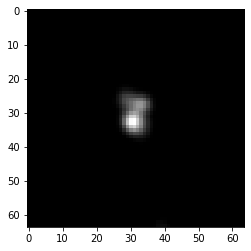

In [6]:
plt.imshow(sample[0][0][0], cmap='gray')
plt.show()

In [7]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [8]:
def train_step_vae(mode, device, data_loader, optim, epoch, loss_fun, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_r_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(data, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        output = model(data)

        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        loss = r_loss + (beta * g_loss)
        avg_r_loss += r_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:4.4f}\tR_Loss: {:4.4f}\tDKL: {:4.4f}'
        s = s.format(epoch, batch_sum, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()/len(data),
                     r_loss.item()/len(data), g_loss.item()/len(data))
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s, avg_r_loss / batch_sum

In [9]:
def test_step_vae(model, device, data_loader, loss_fun, learn_rot=False):
    model.eval()
    avg_r_loss = 0
    batch_sum = 0 
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)
            # BCE Loss
            r_loss , g_loss = loss_fun(output, data)
            avg_r_loss += r_loss.item()
            
    return avg_r_loss / batch_sum

In [10]:
device = 'cuda'
epochs = 40

Train Epoch:   1 [139800/139800 (100%)]	Loss: 29.0517	R_Loss: 29.0513	DKL: 0.0001	AvgR 57.4933	Test Loss : 1.6859   Time : 251.26s
Beta : 4.2870938501451725
Train Epoch:   2 [139800/139800 (100%)]	Loss: 15.8238	R_Loss: 15.6037	DKL: 0.0513	AvgR 5.8364	Test Loss : 0.6712   Time : 252.90s
Beta : 2.7702189362218492
Train Epoch:   3 [139800/139800 (100%)]	Loss: 14.1389	R_Loss: 13.2343	DKL: 0.3265	AvgR 2.8637	Test Loss : 0.5325   Time : 251.34s
Beta : 2.0406093184969154
Train Epoch:   4 [139800/139800 (100%)]	Loss: 12.3550	R_Loss: 11.2466	DKL: 0.5432	AvgR 2.4497	Test Loss : 0.4944   Time : 255.81s
Beta : 1.6475245920252577
Train Epoch:   5 [139800/139800 (100%)]	Loss: 11.8178	R_Loss: 10.6848	DKL: 0.6877	AvgR 2.3388	Test Loss : 0.4839   Time : 257.10s
Beta : 1


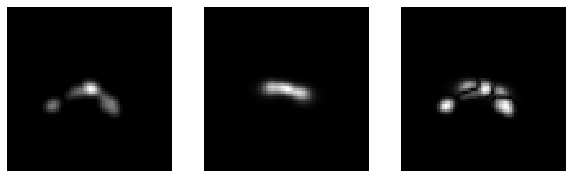

Train Epoch:   6 [139800/139800 (100%)]	Loss: 11.3131	R_Loss: 10.5544	DKL: 0.7587	AvgR 2.2201	Test Loss : 0.4639   Time : 251.29s
Beta : 1
Train Epoch:   7 [139800/139800 (100%)]	Loss: 10.7477	R_Loss: 9.8694	DKL: 0.8784	AvgR 2.1781	Test Loss : 0.4590   Time : 250.21s
Beta : 1
Train Epoch:   8 [139800/139800 (100%)]	Loss: 10.5396	R_Loss: 9.6406	DKL: 0.8990	AvgR 2.1536	Test Loss : 0.4769   Time : 254.33s
Beta : 1
Train Epoch:   9 [139800/139800 (100%)]	Loss: 10.5536	R_Loss: 9.7676	DKL: 0.7860	AvgR 2.1412	Test Loss : 0.4694   Time : 253.28s
Beta : 1
Train Epoch:  10 [139800/139800 (100%)]	Loss: 10.3047	R_Loss: 9.5404	DKL: 0.7643	AvgR 2.1315	Test Loss : 0.4583   Time : 255.04s
Beta : 1


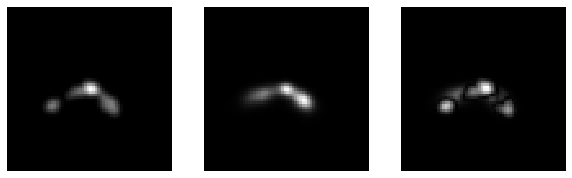

Train Epoch:  11 [139800/139800 (100%)]	Loss: 10.4660	R_Loss: 9.5617	DKL: 0.9042	AvgR 2.1237	Test Loss : 0.4693   Time : 251.81s
Beta : 1
Train Epoch:  12 [139800/139800 (100%)]	Loss: 9.8751	R_Loss: 9.0367	DKL: 0.8384	AvgR 2.1163	Test Loss : 0.4533   Time : 251.79s
Beta : 1
Train Epoch:  13 [139800/139800 (100%)]	Loss: 10.3029	R_Loss: 9.3616	DKL: 0.9413	AvgR 2.1120	Test Loss : 0.4621   Time : 251.35s
Beta : 1
Train Epoch:  14 [139800/139800 (100%)]	Loss: 10.1572	R_Loss: 9.3514	DKL: 0.8058	AvgR 2.1085	Test Loss : 0.4545   Time : 251.16s
Beta : 1
Train Epoch:  15 [139800/139800 (100%)]	Loss: 9.7250	R_Loss: 8.9368	DKL: 0.7883	AvgR 2.1045	Test Loss : 0.4586   Time : 252.90s
Beta : 1


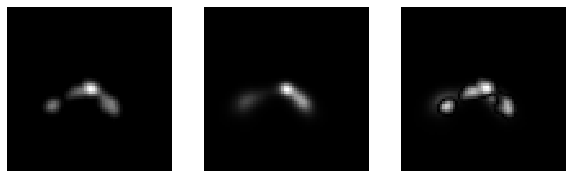

Train Epoch:  16 [139800/139800 (100%)]	Loss: 9.9573	R_Loss: 9.1092	DKL: 0.8481	AvgR 2.1020	Test Loss : 0.4465   Time : 251.64s
Beta : 1
Train Epoch:  17 [139800/139800 (100%)]	Loss: 10.1571	R_Loss: 9.2613	DKL: 0.8958	AvgR 2.0995	Test Loss : 0.4716   Time : 252.70s
Beta : 1
Train Epoch:  18 [139800/139800 (100%)]	Loss: 10.3902	R_Loss: 9.4717	DKL: 0.9185	AvgR 2.0963	Test Loss : 0.4475   Time : 253.35s
Beta : 1
Train Epoch:  19 [139800/139800 (100%)]	Loss: 10.4585	R_Loss: 9.6433	DKL: 0.8152	AvgR 2.0947	Test Loss : 0.4742   Time : 252.36s
Beta : 1
Train Epoch:  20 [139800/139800 (100%)]	Loss: 10.0504	R_Loss: 9.2078	DKL: 0.8426	AvgR 2.0922	Test Loss : 0.4520   Time : 254.55s
Beta : 1


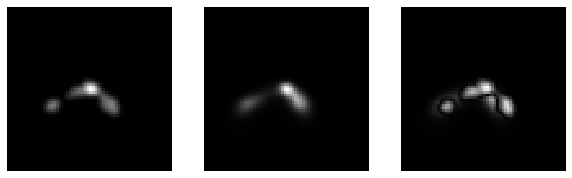

Train Epoch:  21 [139800/139800 (100%)]	Loss: 10.1073	R_Loss: 9.1531	DKL: 0.9542	AvgR 2.0904	Test Loss : 0.4832   Time : 251.15s
Beta : 1
Train Epoch:  22 [139800/139800 (100%)]	Loss: 9.8831	R_Loss: 8.9735	DKL: 0.9095	AvgR 2.0901	Test Loss : 0.4681   Time : 251.10s
Beta : 1
Train Epoch:  23 [139800/139800 (100%)]	Loss: 10.1845	R_Loss: 9.3544	DKL: 0.8300	AvgR 2.0882	Test Loss : 0.4582   Time : 253.20s
Beta : 1
Train Epoch:  24 [139800/139800 (100%)]	Loss: 10.2340	R_Loss: 9.2994	DKL: 0.9346	AvgR 2.0866	Test Loss : 0.4640   Time : 254.46s
Beta : 1
Train Epoch:  25 [139800/139800 (100%)]	Loss: 9.9855	R_Loss: 9.1977	DKL: 0.7878	AvgR 2.0864	Test Loss : 0.4633   Time : 252.57s
Beta : 1


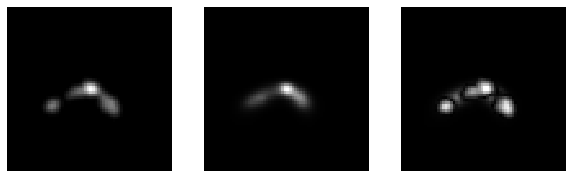

Train Epoch:  26 [139800/139800 (100%)]	Loss: 10.2016	R_Loss: 9.2864	DKL: 0.9151	AvgR 2.0835	Test Loss : 0.4606   Time : 256.50s
Beta : 1
Train Epoch:  27 [139800/139800 (100%)]	Loss: 9.9181	R_Loss: 9.0431	DKL: 0.8750	AvgR 2.0831	Test Loss : 0.4569   Time : 253.43s
Beta : 1
Train Epoch:  28 [139800/139800 (100%)]	Loss: 10.1220	R_Loss: 9.1971	DKL: 0.9249	AvgR 2.0816	Test Loss : 0.4673   Time : 252.29s
Beta : 1
Train Epoch:  29 [139800/139800 (100%)]	Loss: 9.9858	R_Loss: 9.0687	DKL: 0.9171	AvgR 2.0808	Test Loss : 0.4618   Time : 251.26s
Beta : 1
Train Epoch:  30 [139800/139800 (100%)]	Loss: 10.1627	R_Loss: 9.2813	DKL: 0.8813	AvgR 2.0803	Test Loss : 0.4516   Time : 253.86s
Beta : 1


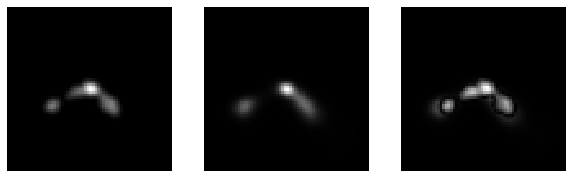

Train Epoch:  31 [139800/139800 (100%)]	Loss: 9.7690	R_Loss: 8.8933	DKL: 0.8757	AvgR 2.0787	Test Loss : 0.4629   Time : 255.45s
Beta : 1
Train Epoch:  32 [139800/139800 (100%)]	Loss: 9.8941	R_Loss: 9.0108	DKL: 0.8833	AvgR 2.0779	Test Loss : 0.4772   Time : 255.86s
Beta : 1
Train Epoch:  33 [139800/139800 (100%)]	Loss: 9.7895	R_Loss: 8.9207	DKL: 0.8689	AvgR 2.0787	Test Loss : 0.4623   Time : 251.76s
Beta : 1
Train Epoch:  34 [139800/139800 (100%)]	Loss: 10.0313	R_Loss: 9.1241	DKL: 0.9072	AvgR 2.0770	Test Loss : 0.4461   Time : 250.99s
Beta : 1
Train Epoch:  35 [139800/139800 (100%)]	Loss: 10.0928	R_Loss: 9.1871	DKL: 0.9057	AvgR 2.0753	Test Loss : 0.4498   Time : 252.83s
Beta : 1


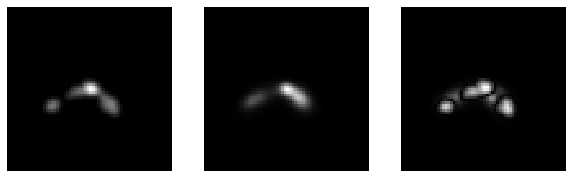

Train Epoch:  36 [139800/139800 (100%)]	Loss: 9.7498	R_Loss: 8.8558	DKL: 0.8940	AvgR 2.0742	Test Loss : 0.4608   Time : 251.83s
Beta : 1
Train Epoch:  37 [139800/139800 (100%)]	Loss: 9.9806	R_Loss: 9.0903	DKL: 0.8903	AvgR 2.0733	Test Loss : 0.4633   Time : 251.05s
Beta : 1
Train Epoch:  38 [139800/139800 (100%)]	Loss: 9.9968	R_Loss: 9.1603	DKL: 0.8365	AvgR 2.0734	Test Loss : 0.4449   Time : 251.59s
Beta : 1
Train Epoch:  39 [139800/139800 (100%)]	Loss: 10.0698	R_Loss: 9.1776	DKL: 0.8921	AvgR 2.0733	Test Loss : 0.4787   Time : 251.28s
Beta : 1
Train Epoch:  40 [139800/139800 (100%)]	Loss: 10.1478	R_Loss: 9.2601	DKL: 0.8877	AvgR 2.0723	Test Loss : 0.4626   Time : 251.92s
Beta : 1


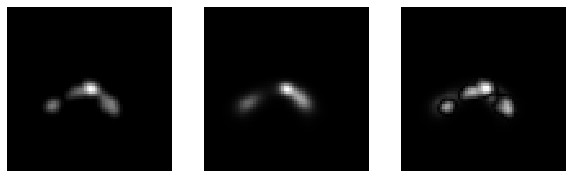

In [14]:
k = [1, 16, 'M', 32, 'M', 64, 64,'M', 64, 'M', 128, 128, 'M', 256]
model = VAE(lt_dim=8, k=k).to(device)
# model = vae_models.VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1E-5)
loss_fun = VAE_Loss()

train_loss = []
test_loss  = []
beta = 8
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s, l = train_step_vae(model, device, data_loader_unlrg, optimizer, epoch, loss_fun=loss_fun, beta=beta)
    loss = test_step_vae(model, device, data_loader_lrg, loss_fun=loss_fun)
    
    train_loss.append(l)
    test_loss.append(loss)
    t = time.time() - start
    
    sys.stdout.write('{}\tAvgR {:.4f}\tTest Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, l, loss, t))
    
#     if epoch % 5 == 0 : 
    beta = beta**.7 if beta > 2 else 1
    print('Beta : {}'.format(beta))
    if epoch % 5 == 0: 
        f, ax = plt.subplots(1, 3, figsize=(10, 5))
        o = model(sample[0].to(device))
        ax[0].imshow(sample[0][1][0], cmap='gray')
        ax[1].imshow(o[0][1][0].detach().cpu(), cmap='gray')
        diff = sample[0][1][0] - o[0][1][0].detach().cpu()
        ax[2].imshow(np.abs(diff), cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

In [ ]:
i = 1
plt.imshow(sample[0][i][0])

In [ ]:
o = model(sample[0].to(device))

In [ ]:
# o.shape

In [ ]:
plt.imshow(o[0][i][0].detach().cpu())

In [16]:
torch.save(model, 'SimpleBVAE_pow_07') 

In [ ]:
s = sample[0][i:i+1]